In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

T_max = 9300 #時間の最大値
T_learn = 3000 #学習時間
T_sleep = 8400 #睡眠期間
T_test = 9300 #想起時間
dt = 0.1 #時間の刻み幅

NT = 10 #ニューロンの縦の個数
NY = 3 #ニューロンの横の個数
tauv = 10 #処理ニューロンの時定数
tauu = 10 #抑制ニューロンの時定数
tauw = 1000 #処理ニューロン同士の重みの時定数
taus = 30 #活性化関数の時定数
tausu = 30 #抑制ニューロンの活性化関数の時定数
we = 1.0 #処理から抑制への重み
wi = -0.5 #抑制から処理への重み

I_learn = 10.0 #学習時の入力電位
I_sleep = 5.0 #睡眠時の入力電位
I_test = 7.0 #想起時の入力電位

Lmd = 1.0 #活性化関数のλ
Lmd_learn = 0.08 #学習係数
ns_ = -3.0 #ノイズの下限
ns = 3.0 #ノイズの上限

S_pre = 0.0

#初期化
V = np.zeros((NT,NY)) #処理ニューロンの膜電位
S = np.zeros((NT,NY)) #処理ニューロンの活性化関数
U = np.zeros((NT,NY)) #抑制ニューロンの膜電位
Su = np.zeros((NT,NY)) #抑制ニューロンの活性化関数
W = np.zeros((NT,NY,NT,NY)) #処理ニューロン同士の重み
I = np.zeros((NT,NY)) #入力電流
Vth = np.zeros((NT,NY)) #処理ニューロンの膜電位の閾値
Uth = np.zeros((NT,NY)) #抑制ニューロンの膜電位の閾値
ham1_base = np.zeros((NT,NY)) #ハミング距離計測のための元データ
ham2_base = np.zeros((NT,NY)) 
ham3_base = np.zeros((NT,NY))
for i in np.arange(NT):
    ham1_base[i][0] = 1
    ham2_base[i][1] = 1
    ham3_base[i][2] = 1

V_save = []
TV_save = []
U_save = []
TU_save = []
V00_save = []
V01_save = []
V02_save = []
U00_save = []
SU00_save = []
T_save = []
S00_save = []
S01_save = []

W0010_save = []
W0011_save = []


#閾値の設定
for i in np.arange(NT):
    for j in np.arange(NY):
        Vth[i][j] = 9.0
        Uth[i][j] = 9.0


def func(tauf, vf, inputf): #ルンゲクッタの中の計算式
    return (-vf+inputf) / tauf

def runge(tau, vr, inputr): #ルンゲクッタの処理
    kv = 0.0
    k = np.zeros(4)
    k[0] = dt * func(tau, vr, inputr)
    k[1] = dt * func(tau, vr + k[0] /2.0, inputr)
    k[2] = dt * func(tau, vr + k[1] /2.0, inputr)
    k[3] = dt * func(tau, vr + k[2], inputr)
    kv = (k[0] + 2*k[1] + 2*k[2] + k[3])/6.0
    vr = vr + kv
    return vr

def funcS(input1, input2i, input2j, input3):
    inputu = 0.0
    inputo = 0.0
    inputs = 0.0
    
    inputu = wi * input1
    
    for k in np.arange(NT):
        for l in np.arange(NY):
            inputo = inputo + (W[input2i][input2j][k][l]*S[k][l])
    
    inputs = inputu + inputo + input3
    return inputs
    

In [ ]:
count = 0
for t in np.arange(0.0,T_max,dt): #0からT_maxまでdt刻みで繰り返す
    
    count_q2 = count / 1000
    count_r2 = count % 1000

    if t < T_learn:#学習期間
        
        if count_q2 % 3 == 0:
            for i in np.arange(NT):
                I[i][0] = I_learn
                I[i][1] = 0.0
                I[i][2] = 0.0
        if count_q2 % 3 == 1:
            for i in np.arange(NT):
                I[i][0] = 0.0
                I[i][1] = I_learn
                I[i][2] = 0.0
        if count_q2 % 3 == 2:
            for i in np.arange(NT):
                I[i][0] = 0.0
                I[i][1] = 0.0
                I[i][2] = I_learn
    
    elif T_sleep > t > T_learn: #睡眠期間
        
        if (count//6000) % 2 == 0:
            for i in np.arange(NT):
                for j in np.arange(NY):
                    Vth[i][j] = 4.0
        else:
            for i in np.arange(NT):
                for j in np.arange(NY):
                    Vth[i][j] = 9.0
        
        if count_q2 % 3 == 0:
            for i in np.arange(NT):
                for j in np.arange(NY):
                    if j % 3 == 0:
                        I[i][j] = I_sleep
                    else:
                        I[i][j] = 0.0
        if count_q2 % 3 == 1:
            for i in np.arange(NT):
                for j in np.arange(NY):
                    if j % 3 == 1:
                        I[i][j] = I_sleep
                    else:
                        I[i][j] = 0.0
        if count_q2 % 3 == 2:
            for i in np.arange(NT):
                for j in np.arange(NY):
                    if j % 3 == 2:
                        I[i][j] = I_sleep
                    else:
                        I[i][j] = 0.0
                    

    
    else: #想起期間　呼び出したいメモリ以外にはbase電流が入る
        for i in np.arange(NT):
            for j in np.arange(NY):
                Vth[i][j] = 9.0
        
        if count_q2 % 3 == 0:
            for i in np.arange(NT):
                I[i][0] = I_test + random.uniform(ns_,ns)
                I[i][1] = 0.0
                I[i][2] = 0.0
        if count_q2 % 3 == 1:
            for i in np.arange(NT):
                I[i][0] = 0.0
                I[i][1] = I_test + random.uniform(ns_,ns)
                I[i][2] = 0.0
        if count_q2 % 3 == 2:
            for i in np.arange(NT):
                I[i][0] = 0.0
                I[i][1] = 0.0
                I[i][2] = I_test + random.uniform(ns_,ns)
        
    
    for i in np.arange(NT):
        for j in np.arange(NY):
                
            if V[i][j] >= Vth[i][j]: #処理ニューロンが閾値を超えたら
                
                S[i][j] = runge(taus, S[i][j],0) + Lmd#活性化関数に+λ
                V[i][j] = 20.0 #処理ニューロンの膜電位の発火
                    
                #発火タイミングを記録
                V_save.append(i + j*10)
                TV_save.append(t)
                    
                V[i][j] = 0.0 #0に戻す
            else:
                S[i][j] = runge(taus, S[i][j],0)
                    
            if I[i][j] > 0 and U[i][j] >= Uth[i][j]: #抑制ニューロンの膜電位が閾値を超えたら
                Su[i][j] = runge(tausu, Su[i][j],0) + Lmd
                
                U[i][j] = 20.0 #抑制ニューロンの膜電位の発火
                    
                #発火タイミングを記録
                U_save.append(i + j*10)
                TU_save.append(t)
                    
                U[i][j] = 0.0
            else:
                Su[i][j] = runge(tausu, Su[i][j],0)
                
            #膜電位の更新
            #処理ニューロンの膜電位の更新
            I_sum = 0.0
            I_sum = funcS(Su[i][j], i, j, I[i][j])
            V[i][j] = runge(tauv, V[i][j], I_sum)
            #抑制ニューロンの膜電位の更新
            Iu = 0.0
            Iu = we * S[i][j]
            U[i][j] = runge(tauu, U[i][j], Iu)
    
    if t < T_sleep:
        #重みの更新
        for i in np.arange(NT):
            for j in np.arange(NY):
                for k in np.arange(NT):
                    for l in np.arange(NY):
                        if i == k and j == l:
                            W[i][j][k][l] = 0.0
                        else:
                            IW = 0.0
                            if I[i][j] == I[k][l]:
                                module = 1.0
                            else:
                                module = 0.1
                            IW = Lmd_learn * S[i][j] * S[k][l] * module
                            W[i][j][k][l] = runge(tauw, W[i][j][k][l], IW)
    else:
        pass
                            
    #重みの変化を記録
    T_save.append(t)
    W0010_save.append(W[0][0][1][0])
    W0011_save.append(W[0][0][1][1])
    S00_save.append(S[0][0])
    S01_save.append(S[0][1])
    if V[0][0] >= Vth[0][0] :
        V00_save.append(20)
    else:
        V00_save.append(V[0][0])
    if V[0][1] >= Vth[0][1] :
        V01_save.append(20)
    else:
        V01_save.append(V[0][1])
    if V[0][2] >= Vth[0][2] :
        V02_save.append(20)
    else:
        V02_save.append(V[0][2])

    if U[0][0] >= Uth[0][0]:
        U00_save.append(20)
    else:
        U00_save.append(U[0][0])
    SU00_save.append(Su[0][0])
    

        
    count = count + 1

plt.plot(TV_save, V_save, '.')
plt.xlabel("t")
plt.ylabel("neuron number")
plt.show()

plt.plot(TU_save, U_save, '.')
plt.xlabel("t")
plt.ylabel("neuron number")
plt.show()

plt.plot(T_save, W0010_save)
plt.xlabel("t")
plt.ylabel("W0010")
plt.show()

plt.plot(T_save, W0011_save)
plt.xlabel("t")
plt.ylabel("W0011")
plt.show()

plt.plot(T_save, V00_save)
plt.xlabel("t")
plt.ylabel("V00")
plt.show()

plt.plot(T_save, V01_save)
plt.xlabel("t")
plt.ylabel("V01")
plt.show()

plt.plot(T_save, V02_save)
plt.xlabel("t")
plt.ylabel("V02")
plt.show()

plt.plot(T_save, U00_save)
plt.xlabel("t")
plt.ylabel("U00")
plt.show()

plt.plot(T_save, S00_save)
plt.xlabel("t")
plt.ylabel("S00")
plt.show()

plt.plot(T_save, SU00_save)
plt.xlabel("t")
plt.ylabel("SU00")
plt.show()


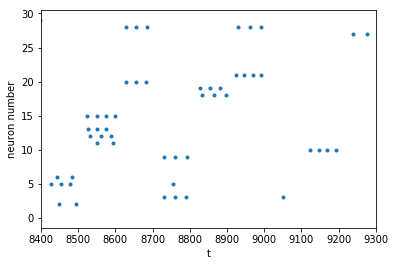

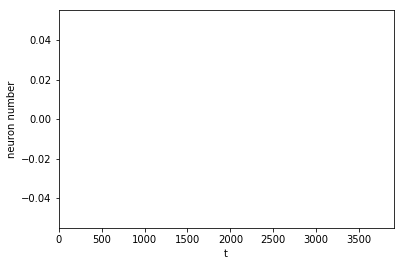

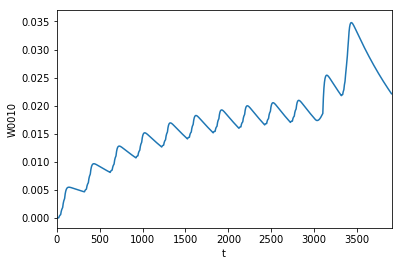

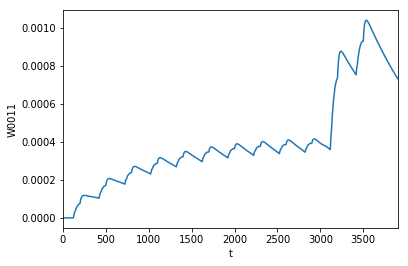

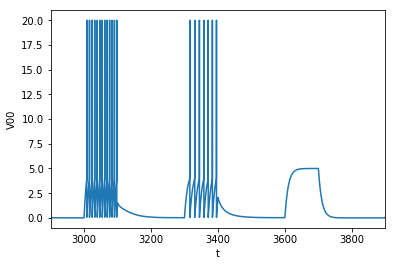

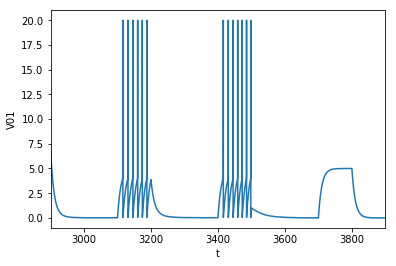

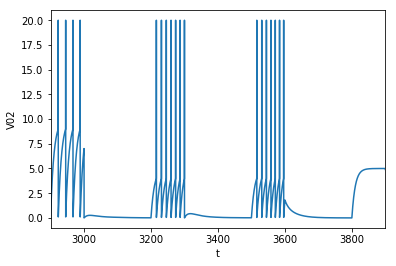

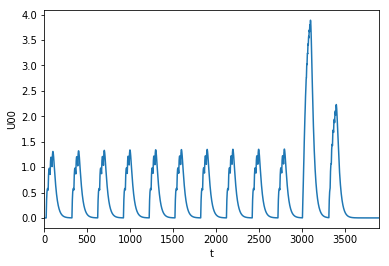

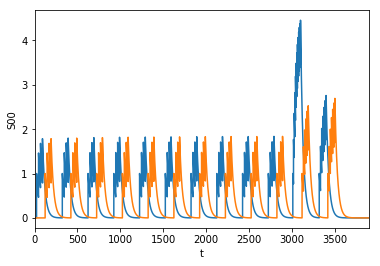

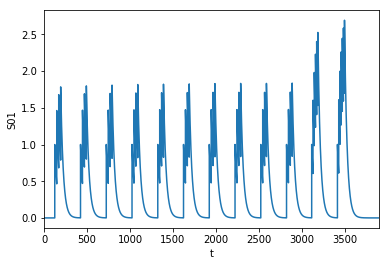

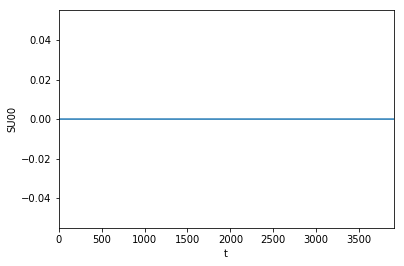

In [162]:
#グラフのプロットのための枠

plt.plot(TV_save, V_save, '.')
plt.xlabel("t")
plt.ylabel("neuron number")
plt.xlim([8400,9300])
plt.show()

plt.plot(TU_save, U_save, '.')
plt.xlabel("t")
plt.ylabel("neuron number")
plt.xlim([0,3900])
plt.show()

plt.plot(T_save, W0010_save)
plt.xlabel("t")
plt.ylabel("W0010")
plt.xlim([0,3900])
plt.show()

plt.plot(T_save, W0011_save)
plt.xlabel("t")
plt.ylabel("W0011")
plt.xlim([0,3900])
plt.show()

plt.plot(T_save, V00_save)
plt.xlabel("t")
plt.ylabel("V00")
plt.xlim([2900,3900])
plt.show()

plt.plot(T_save, V01_save)
plt.xlabel("t")
plt.ylabel("V01")
plt.xlim([2900,3900])
plt.show()

plt.plot(T_save, V02_save)
plt.xlabel("t")
plt.ylabel("V02")
plt.xlim([2900,3900])
plt.show()

plt.plot(T_save, U00_save)
plt.xlabel("t")
plt.ylabel("U00")
plt.xlim([0, 3900])
plt.show()

plt.plot(T_save, S00_save)
plt.plot(T_save, S01_save)
plt.xlabel("t")
plt.ylabel("S00")
plt.xlim([0,3900])
plt.show()

plt.plot(T_save, S01_save)
plt.xlabel("t")
plt.ylabel("S01")
plt.xlim([0,3900])
plt.show()


plt.plot(T_save, SU00_save)
plt.xlabel("t")
plt.ylabel("SU00")
plt.xlim([0,3900])
plt.show()


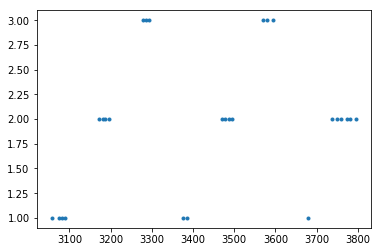

In [114]:
# ハミング距離を測るプログラム

n = 0
delta = 7 #同時発火したとみなす範囲(ms)
error = 2 #10個中エラーをいくつまで許すか
memory = [] 
fire_T = []
while n < len(fire_time):
    a = [i for i in fire_time if fire_time[n]+delta >= i >= fire_time[n]]
    if abs(len(a)-10) <= error:
        for j in range(0, 8):
            if 3000+((j+1)*100) > fire_time[n] >= 3000+(j*100):
                memory.append(1+(j % 3))
                fire_T.append(fire_time[n])
    n = n+len(a)

plt.plot(fire_T, memory,'.')
plt.show()